In [1]:
import sys
sys.path.append("..")

import numpy as np
from numpy import random

from tqdm import tqdm

from pygmo import hypervolume

from utils import utils, plot
import matplotlib.pyplot as plt

# 1. Read metrics data

In [2]:
ref_point = [1.0, 1.0]
lrs_list = [num / 10000 for num in range(5, 105, 5)]
low_betas_list = [num / 100 for num in range(80, 91)]

lrs_arr = np.array(lrs_list)
low_betas_arr = np.array(low_betas_list)

file_name_list = [
    "lr_" + format(lr, "8f").replace(".", "") + "_betas_" + str(low_beta).replace(".", "") + "_0999_metrics.csv"
    for lr in lrs_list 
    for low_beta in low_betas_list
]

lrs_grid, low_betas_grid = np.meshgrid(low_betas_arr, lrs_arr)[::-1]


# Read data

## Adam, weighted
all_adam_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adam" + "/" + file_name)
    for file_name in file_name_list
]
all_adam_matrics_arr = np.row_stack(all_adam_matrics_list)

## Adam, unweighted
all_adam_unweight_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adam_unweighted" + "/" + file_name)
    for file_name in file_name_list
]
all_adam_unweight_matrics_arr = np.row_stack(all_adam_unweight_matrics_list)

## Adamax, weighted
all_adamax_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adamax" + "/" + file_name)
    for file_name in file_name_list
]
all_adamax_matrics_arr = np.row_stack(all_adamax_matrics_list)

## Adamax, unweighted
all_adamax_unweight_matrics_list = [
    utils.ReadFileGetMetrics("../resnet_metrics_TrainTest/Adamax_unweighted" + "/" + file_name)
    for file_name in file_name_list
]
all_adamax_unweight_matrics_arr = np.row_stack(all_adamax_unweight_matrics_list)

# Get true pareto set

true_pareto_set = utils.collect_efficient_solutions(
    all_adam_matrics_list + all_adam_unweight_matrics_list + all_adamax_matrics_list + all_adamax_unweight_matrics_list
)
true_pareto_matrix = np.row_stack(true_pareto_set)

# 2. Plot scatter

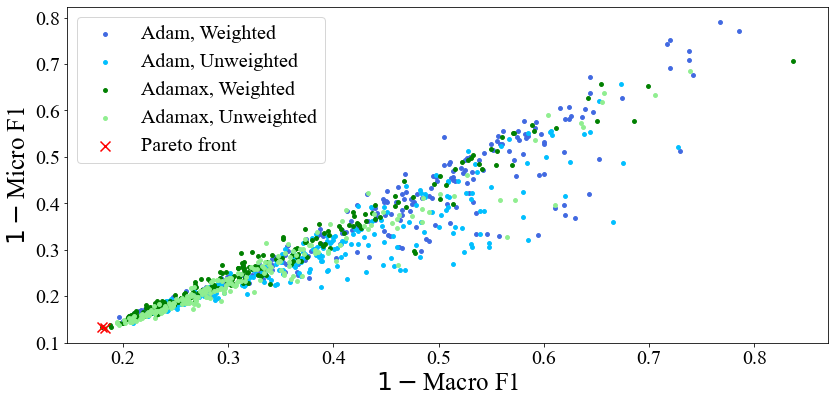

In [3]:
plt.rcParams.update({'font.family':'Times New Roman', 'font.size': 20})

fig, ax = plt.subplots(figsize=(12, 6))

ax.scatter(*all_adam_matrics_arr.T, c='royalblue', s=15, label="Adam, Weighted")
ax.scatter(*all_adam_unweight_matrics_arr.T, c='deepskyblue', s=15, label="Adam, Unweighted")
ax.scatter(*all_adamax_matrics_arr.T, c='green', s=15, label="Adamax, Weighted")
ax.scatter(*all_adamax_unweight_matrics_arr.T, c='lightgreen', s=15, label="Adamax, Unweighted")


ax.scatter(*true_pareto_matrix.T, c='red', s=100, marker="x", label="Pareto front")

ax.set_xlabel(r"$1 - $Macro F1", size=25)
ax.set_ylabel(r"$1 - $Micro F1", size=25)
ax.legend()
plt.tight_layout()
plt.show()

# 3. Compare to random select

In [4]:
# Factors
all_w = np.row_stack([
    np.column_stack([[1] * lrs_grid.size, lrs_grid.reshape(-1), low_betas_grid.reshape(-1)]),
    np.column_stack([[2] * lrs_grid.size, lrs_grid.reshape(-1), low_betas_grid.reshape(-1)]),
    np.column_stack([[3] * lrs_grid.size, lrs_grid.reshape(-1), low_betas_grid.reshape(-1)]),
    np.column_stack([[4] * lrs_grid.size, lrs_grid.reshape(-1), low_betas_grid.reshape(-1)]),
]).astype(np.float32)


# Responses
all_matrics_arr = np.row_stack([
    all_adam_matrics_arr,
    all_adam_unweight_matrics_arr,
    all_adamax_matrics_arr,
    all_adamax_unweight_matrics_arr,
]).astype(np.float32)

y1 = all_matrics_arr[:,0]
y2 = all_matrics_arr[:,1]

In [5]:
# Hypervolume: contribution of true pareto front
hv = hypervolume(true_pareto_set)
true_pareto_contribute = hv.compute(ref_point)

In [9]:
seed_idxs = [
    0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 20, 25, 32, 33, 34, 44, 45, 51,
    53, 60, 62, 65, 69, 78, 80, 83, 87, 95, 99, 104, 114, 115, 121, 138, 146, 151, 154, 170,
    177, 180, 183, 184, 187, 189, 190, 193, 200, 201, 211, 215, 217, 220, 232, 234, 236, 250, 252, 253,
    255, 256, 262, 263, 266, 277, 293, 297, 321, 327, 329, 346, 347, 354, 360, 368, 370, 383, 391, 394,
    395, 396, 397, 401, 404, 409, 416, 422, 425, 427, 428, 432, 434, 445, 448, 450, 464, 471, 476, 480,
]

In [10]:
random_select_cr_lists = []
for r_seed in tqdm(seed_idxs):
    random.seed(r_seed)
    indices = random.randint(low=0, high=880, size=28)
    train_y1, train_y2 = y1[indices], y2[indices]
    cr_list = []
    for i in range(8,29):
        current_pareto_set = utils.collect_efficient_solutions([arr for arr in np.column_stack([train_y1[:i], train_y2[:i]])])
        hv = hypervolume(current_pareto_set)
        current_pareto_contribute = hv.compute(ref_point)
        cr_list.append(current_pareto_contribute / true_pareto_contribute)
    random_select_cr_lists.append(cr_list)

100%|██████████| 100/100 [00:00<00:00, 188.83it/s]


In [11]:
mt_list = [utils.load_object("../experiment_result/real/c2_mtqqgp_ss2_ns1/"+str(i+1)+".pkl") for i in range(100)]
mtpp_list = [utils.load_object("../experiment_result/real/c2_mtqqgp_ss2_ns1_pp/"+str(i+1)+".pkl") for i in range(100)]

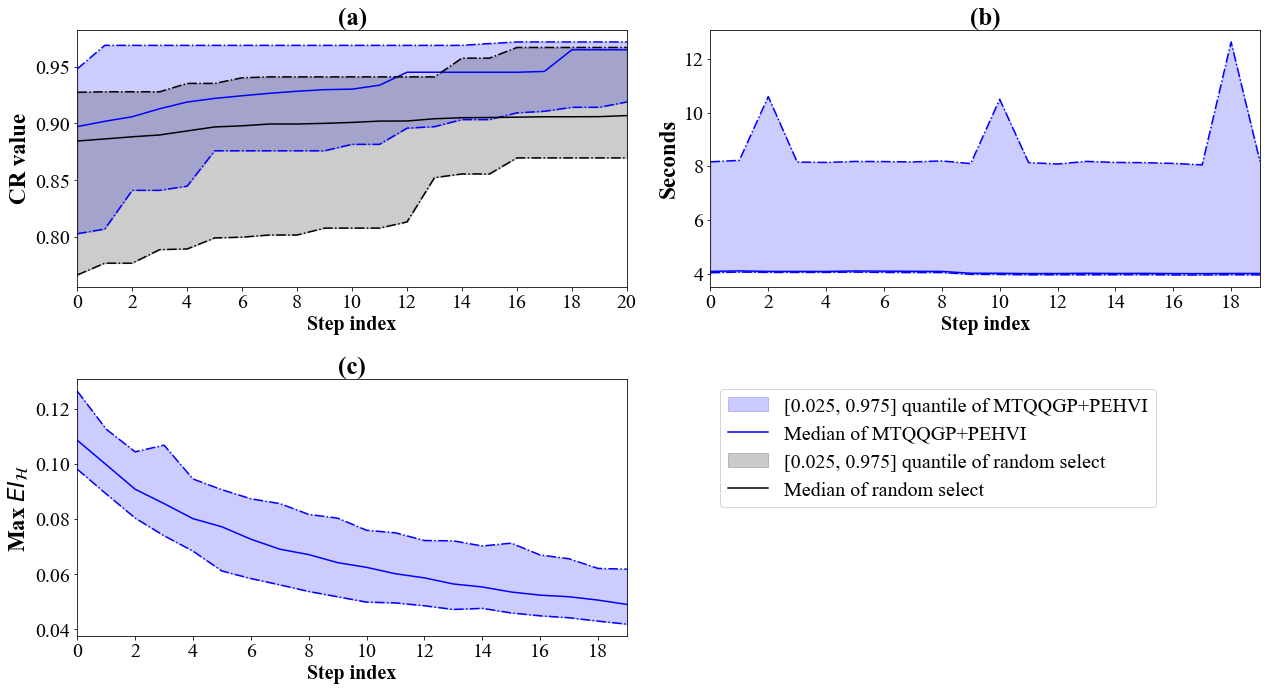

In [12]:
plot.PlotHisQuan(
    cr_lists=[
        [sub_dict["cr"] for sub_dict in mtpp_list],
        random_select_cr_lists
    ],
    time_lists=[
        [sub_dict["time_cost"] for sub_dict in mtpp_list],
    ],
    eiv_lists=[
        [sub_dict["ei_value"] for sub_dict in mtpp_list],
    ],
    step_num_list=[20,19,19],
    model_name_list=["MTQQGP+PEHVI", "random select"],
    color_list=["blue", "black"],
)